In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from fortuna.conformal import EnbPI
from fortuna.metric.regression import prediction_interval_coverage_probability

In [29]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame

In [30]:
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [5]:
df.groupby(["weekday", "hour"])["count"].mean()

weekday  hour
0        0        93.990385
         1        77.432692
         2        61.627451
         3        31.144231
         4         9.362745
                    ...    
6        19      239.932692
         20      180.865385
         21      156.000000
         22      139.663462
         23      115.855769
Name: count, Length: 168, dtype: float64

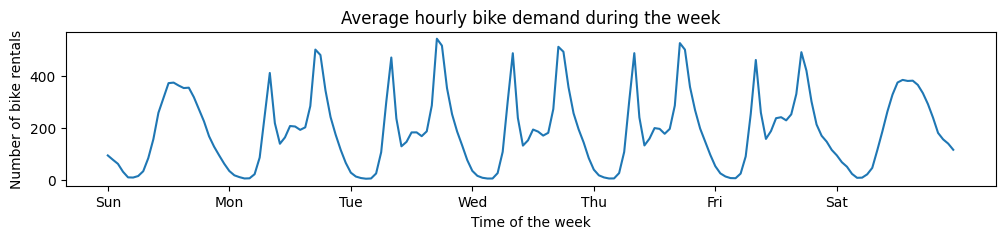

In [6]:
fig, ax = plt.subplots(figsize=(12, 2))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [32]:
df = df.sample(500)
y = df["count"] / df["count"].max()
X = df.drop("count", axis="columns")
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)
     

In [38]:
class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

In [39]:
n_bs_samples = 10
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)
  

In [15]:
bs_indices.shape

(10, 400)

In [16]:
bs_indices

array([[230, 189, 185, ..., 115, 348,  83],
       [318, 259, 356, ...,  20, 152,  78],
       [130, 112,  99, ...,  44,  61,  62],
       ...,
       [128,  77, 319, ..., 332, 107, 253],
       [181, 142, 343, ..., 101, 129, 302],
       [217, 301, 220, ...,  16,  38,  27]])

In [17]:
X_train.shape

(400, 12)

In [18]:
len(bs_train_data)

10

In [19]:
bs_train_data[0][0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
17308,spring,1,12,1,False,6,False,misty,9.84,12.120,0.75,6.0032
9120,spring,1,1,22,False,5,True,misty,8.20,9.850,0.37,15.0013
12413,summer,1,6,10,False,3,True,clear,24.60,31.060,0.46,6.0032
1129,spring,0,2,19,False,6,False,clear,13.94,15.150,0.29,23.9994
8711,spring,1,1,19,False,2,True,clear,4.92,4.545,0.28,27.9993
...,...,...,...,...,...,...,...,...,...,...,...,...
9427,spring,1,2,17,False,4,True,clear,17.22,21.210,0.54,32.9975
4411,fall,0,7,17,False,4,True,clear,35.26,37.880,0.36,16.9979
1715,spring,0,3,3,False,4,True,clear,13.94,16.665,0.66,11.0014
2302,summer,0,4,19,False,0,False,clear,20.50,24.240,0.77,12.9980


In [20]:
bs_train_data[0][1]

17308    0.038662
9120     0.075235
12413    0.212121
1129     0.061651
8711     0.163009
           ...   
9427     0.470219
4411     0.594566
1715     0.002090
2302     0.136886
6294     0.253918
Name: count, Length: 400, dtype: float64

In [21]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

Index([12413,  1129,  8711,  8806,  6026,  6019,  4497,  8711, 12918, 12640,
       ...
        4940,  5324,   893, 14625,  1875,  7918,  6038,  5482,  4411,  6294],
      dtype='int64', length=240)


In [22]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
12413,summer,1,6,10,False,3,True,clear,24.6,31.06,0.46,6.0032
12413,summer,1,6,10,False,3,True,clear,24.6,31.06,0.46,6.0032


In [23]:
categorical_columns = ["weather", "season", "holiday", "workingday"]
categories = [
    ["clear", "misty", "rain", "heavy_rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")

In [24]:
bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)

c:\lumen_2024\Prediction-of-Hotel-Occupancy\prediction-of-hotel-occupancy\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\lumen_2024\Prediction-of-Hotel-Occupancy\prediction-of-hotel-occupancy\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [25]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [26]:
# In order to evaluate conditional coverage, we measure the Prediction Interval Coverage Probability (PICP), i.e. the percentage of
# test target variables that actually falls within the conformal intervals. We further measure the percentage of intervals that contain the point
# predictions given by the model. Finally, we measure the size of the conformal intervals, which EnbPI takes to be the same for every intervals
# if no online feedback is provided, like in this case.
     

In [27]:

print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9599999785423279.
Size of the conformal intervals: 0.455223023891449


In the example above, EnbPI assumes that all the predictions in the test dataset are done at once, without any online feedback from incoming observations of the test targets. As a consequence, the size of the conformal intervals is the same for all test data points.

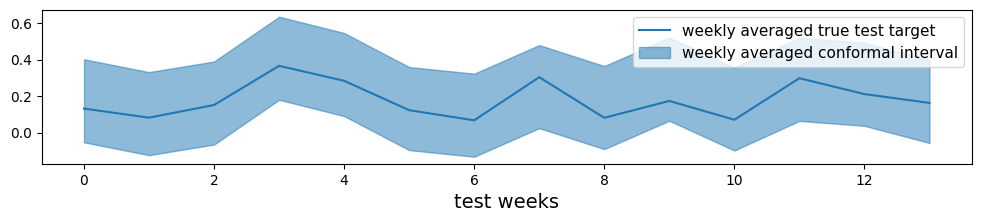

In [28]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
     


EnbPI with online feedback

In [29]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

Similarly as done above, we compute the percentage of predictions and true test targets falling within the conformal intervals. Again, it is good to see that all conformal intervals include the point predictions. Also, the percentage of intervals containing the true targets increased to around 83%, getting closer to the desired coverage of 95%.

In [30]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9599999785423279.


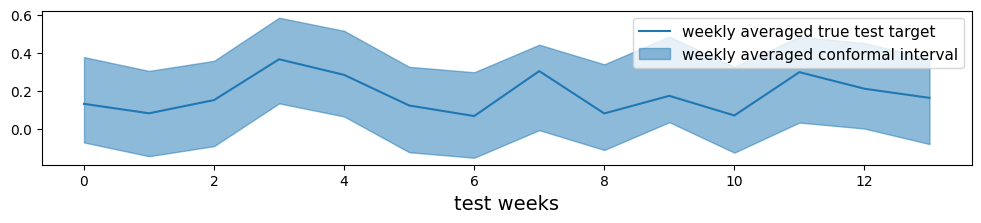

In [31]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

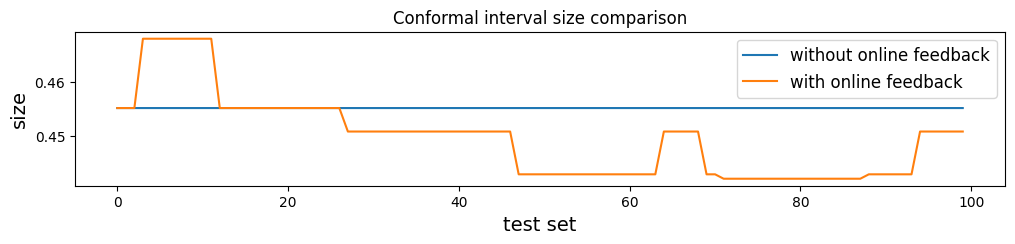

In [32]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(12, 2))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)